In [1]:
#check Pytorch
!module avail pytorch
#Load Pytorch
!module load python3/3.8.6
!module load pytorch/1.7.0
!module load torch

1h=
----------------------- /share/module.7/machine-learning -----------------------
   pytorch/1.0    pytorch/1.3    pytorch/1.5.1    pytorch/1.7.0 (L)
   pytorch/1.1    pytorch/1.5    pytorch/1.6.0    pytorch/1.8.1 (D)

  Where:
   L:  Module is loaded
   D:  Default Module

Use "module spider" to find all possible modules.
Use "module keyword key1 key2 ..." to search for all possible modules matching
any of the "keys".


>
The following have been reloaded with a version change:
  1) python3/3.8.10 => python3/3.8.6



In [2]:
# Imports here
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import cv2

import torch
from torch.autograd import Variable
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split, Sampler, BatchSampler 
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
from PIL import Image, ImageOps
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
from matplotlib.image import imread
from tqdm import tqdm

## Load the original MNIST data


In [6]:
data_dir = 'Data'
train_dir = data_dir + '/training/fashion-mnist_train.csv'
#valid_dir = data_dir + '/valid'
test_dir = data_dir + '/testing/fashion-mnist_test.csv'
train_data = pd.read_csv(train_dir)
test_data = pd.read_csv(test_dir)

In [7]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, data, transform = None):
        """Method to initilaize variables.""" 
        self.fashion_MNIST = list(data.values)
        self.transform = transform
        
        label = []
        image = []
        
        for i in self.fashion_MNIST:
            # first column is of labels.
            label.append(i[1])
            image.append(i[2:])
        self.labels = np.asarray(label)
        # Dimension of Images = 28 * 28 * 1. where height = width = 28 and color_channels = 1.
        self.images = np.asarray(image).reshape(-1, 28, 28, 1).astype('float32')

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [32]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(torch.cuda.is_available())
# Transform data into Tensor that has a range from 0 to 1
train_set = FashionDataset(train_data, transform=transforms.Compose([transforms.ToTensor()]))
test_set = FashionDataset(test_data, transform=transforms.Compose([transforms.ToTensor()]))

print(np.size(train_set.images,0),np.size(train_set.images,1),np.size(train_set.images,2))
print(np.size(test_set.images,0),np.size(test_set.images,1),np.size(test_set.images,2))

True
60000 28 28
10000 28 28


## Cross validation

In [9]:
class ImageSampler(Sampler):
    def __init__(self, 
                 sample_idx,
                 data_source='Data/training/fashion-mnist_train.csv'):
        super().__init__(data_source)
        self.sample_idx = sample_idx
        self.df_images = pd.read_csv(data_source)
        
    def __iter__(self):
        image_ids = self.df_images['image_id'].loc[self.sample_idx]
        return iter(image_ids)
    
    def __len__(self):
        return len(self.sample_idx)

class ImageBatchSampler(BatchSampler):
    def __init__(self, 
                 sampler,
                 aug_count=4,
                 batch_size=100,
                 drop_last=True):
        super().__init__(sampler, batch_size, drop_last)
        self.aug_count = aug_count
        assert self.batch_size % self.aug_count == 0, 'Batch size must be an integer multiple of the aug_count.'
        
    def __iter__(self):
        batch = []
        
        for image_id in self.sampler:
            for i in range(self.aug_count):
                batch.append(image_id)
            if len(batch) == self.batch_size:
                yield batch
                batch = []
        if len(batch) > 0 and not self.drop_last:
            yield batch
    
    def __len__(self):
        if self.drop_last:
            return len(self.sampler) // self.batch_size
        else:
            return (len(self.sampler) + self.batch_size - 1) // self.batch_size
            
def create_split_loaders(dataset, split, aug_count, batch_size):
    train_folds_idx = split[0]
    valid_folds_idx = split[1]
    train_sampler = ImageSampler(train_folds_idx)
    valid_sampler = ImageSampler(valid_folds_idx)
    train_batch_sampler = ImageBatchSampler(train_sampler, 
                                            aug_count, 
                                            batch_size)
    valid_batch_sampler = ImageBatchSampler(valid_sampler, 
                                            aug_count=1, 
                                            batch_size=batch_size,
                                            drop_last=False)
    train_loader = DataLoader(dataset, batch_sampler=train_batch_sampler)
    valid_loader = DataLoader(dataset, batch_sampler=valid_batch_sampler)
    return (train_loader, valid_loader)  

In [10]:
def get_all_split_loaders(dataset, cv_splits, aug_count=4, batch_size=100):
    """Create DataLoaders for each split"""
    split_samplers = []
    
    for i in range(len(cv_splits)):
        split_samplers.append(
            create_split_loaders(dataset,
                                 cv_splits[i], 
                                 aug_count, 
                                 batch_size)
        )
    return split_samplers

## Split and create dataloader

In [11]:
splitter = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)

splits = []
for train_idx, test_idx in splitter.split(train_data['image_id'],train_data['label']):
    splits.append((train_idx, test_idx))

In [12]:
dataloaders = get_all_split_loaders(train_set, splits, aug_count=2, batch_size=10)

## Label mapping

In [13]:
def output_label(label):
    output_mapping = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

# Building the classifier

In [14]:
class FashionCNN(nn.Module):
    
    def __init__(self):
        super(FashionCNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [44]:
model = FashionCNN()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-3)


## Training the classifier

In [45]:
num_epochs = 5
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
valid_loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []
for train_batch_loader, valid_batch_loader in tqdm(dataloaders):
    for epoch in tqdm(range(num_epochs)):
        train_correct = 0
        train_total = 0
        print(epoch)
        for images, labels in train_batch_loader:
            # Transfering images and labels to GPU if available
            images, labels = images.to(device), labels.to(device)

            train = Variable(images.view(10, 1, 28, 28))
            labels = Variable(labels)

            # Forward pass 
            outputs = model(train)
            loss = error(outputs, labels)
            
            predictions = torch.max(outputs, 1)[1].to(device)
            train_correct += (predictions == labels).sum()
            train_total += len(labels)
            train_accuracy = train_correct * 100 / train_total

            # Initializing a gradient as 0 so there is no mixing of gradient among the batches
            optimizer.zero_grad()

            #Propagating the error backward
            loss.backward()

            # Optimizing the parameters
            optimizer.step()

            count += 1

            # Turn off gradients for validation, saves memory and computation
            with torch.no_grad():
            # Set the model to evaluation mode
                model.eval()

                # Validation pass

                if not (count % 50):    # It's same as "if count % 50 == 0"
                    total = 0
                    correct = 0
                    valid_loss = 0

                    for images, labels in valid_batch_loader:
                        images, labels = images.to(device), labels.to(device)
                        labels_list.append(labels)

                        validation = Variable(images.view(10, 1, 28, 28))

                        outputs = model(images)

                        valid_loss += error(outputs, labels)

                        predictions = torch.max(outputs, 1)[1].to(device)
                        predictions_list.append(predictions)
                        correct += (predictions == labels).sum()

                        total += len(labels)

                    model.train()
                    accuracy = correct * 100 / total
                    loss_list.append(loss.data/len(train_batch_loader))
                    valid_loss_list.append(valid_loss/len(valid_batch_loader))
                    iteration_list.append(count)
                    accuracy_list.append(accuracy)



print("Iteration: {}, Train_Loss: {}, Valid_Loss: {}, Train_Accuracy: {}, Valid_Accuracy: {}%".format(count, loss.data/len(train_batch_loader), valid_loss/len(valid_batch_loader), train_accuracy, accuracy))


  0%|          | 0/5 [00:00<?, ?it/s]

0



 20%|██        | 1/5 [03:03<12:13, 183.36s/it]

1



 40%|████      | 2/5 [06:06<09:09, 183.22s/it]

2



 60%|██████    | 3/5 [09:09<06:06, 183.14s/it]

3



 80%|████████  | 4/5 [12:13<03:03, 183.37s/it]

4



  0%|          | 0/5 [00:00<?, ?it/s]

0



 20%|██        | 1/5 [03:03<12:13, 183.47s/it]

1



 40%|████      | 2/5 [06:05<09:08, 182.68s/it]

2



 60%|██████    | 3/5 [09:16<06:12, 186.31s/it]

3



 80%|████████  | 4/5 [12:22<03:06, 186.39s/it]

4



  0%|          | 0/5 [00:00<?, ?it/s]

0



 20%|██        | 1/5 [03:06<12:27, 186.94s/it]

1



 40%|████      | 2/5 [06:12<09:19, 186.41s/it]

2



 60%|██████    | 3/5 [09:19<06:13, 186.50s/it]

3



 80%|████████  | 4/5 [12:28<03:07, 187.60s/it]

4



  0%|          | 0/5 [00:00<?, ?it/s]

0



 20%|██        | 1/5 [03:06<12:27, 186.99s/it]

1



 40%|████      | 2/5 [06:12<09:18, 186.32s/it]

2



 60%|██████    | 3/5 [09:16<06:10, 185.09s/it]

3



 80%|████████  | 4/5 [12:20<03:04, 184.65s/it]

4



  0%|          | 0/5 [00:00<?, ?it/s]

0



 20%|██        | 1/5 [03:06<12:26, 186.69s/it]

1



 40%|████      | 2/5 [06:07<09:10, 183.45s/it]

2



 60%|██████    | 3/5 [09:09<06:05, 182.60s/it]

3



 80%|████████  | 4/5 [12:10<03:02, 182.08s/it]

4



  0%|          | 0/5 [00:00<?, ?it/s]

0



 20%|██        | 1/5 [03:04<12:19, 184.76s/it]

1



 40%|████      | 2/5 [06:06<09:08, 182.86s/it]

2



 60%|██████    | 3/5 [09:07<06:04, 182.29s/it]

3



 80%|████████  | 4/5 [12:09<03:01, 181.98s/it]

4



100%|██████████| 6/6 [1:32:06<00:00, 921.14s/it]

Iteration: 300000, Train_Loss: 1.2795069778803736e-05, Valid_Loss: 0.2891687750816345, Train_Accuracy: 89.43099975585938, Valid_Accuracy: 89.63999938964844%


In [46]:
def test(model,loader):
    predictions_arr = np.array([50])
    true_labels_arr = np.array([50])

    # Do validation on the test set
    model.eval()
    model.to(device)

    with torch.no_grad():
        
        total = 0
        correct = 0
        test_loss = 0
        accuracy = 0
    
        for i, (images, labels) in enumerate(loader):
    
            images, labels = images.to(device), labels.to(device)
        
            
            curr_label = labels.cpu().detach().flatten().numpy()
            true_labels_arr = np.hstack((true_labels_arr, curr_label))
            #test = Variable(images.view(10, 1, 28, 28))
            try:
                test = Variable(images.view(10, 1, 28, 28))
            except BaseException:
                test = Variable(images.view(5, 1, 28, 28))
                
            outputs = model(test)
            probabilities = torch.exp(outputs)
            #test_loss += error(outputs, labels)

            predictions = torch.max(outputs, 1)[1].to(device)
            curr_prediction = predictions.cpu().detach().numpy()
            predictions_arr = np.hstack((predictions_arr, curr_prediction))
            correct += (predictions == labels.flatten()).sum().item()
            total += len(labels)
         
        print(correct, total)
        accuracy = (correct / total) * 100


        print("Test Accuracy: {}%".format(accuracy)) 
        
        predictions_arr = predictions_arr[1:]
        true_labels_arr = true_labels_arr[1:]
    
    return accuracy, true_labels_arr, predictions_arr

In [47]:
test_loader = DataLoader(test_set, batch_size=10)

In [48]:
accuracy, true_labels, predictions = test(model,test_loader)

9000 10000
Test Accuracy: 90.0%


In [49]:
print(true_labels.shape)
print(predictions.shape)

(10000,)
(10000,)


# Test on different data

## Define MNIST categories

In [50]:
class FashionCategories:

    def __init__(self):
        self.categories = {0: 'T-shirt/top', 1 : 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot' }
        
    def __str__(self):
        retstr = 'Categories:\n'
        for label, clothing in self.categories.items():
            retstr += str(label) + ': ' + clothing + '\n'
        return retstr
    
categories = FashionCategories()

## Read in new testing data

Layout
Images: (30175, 80, 60, 3)
Lables: (30175, 1)

Examples


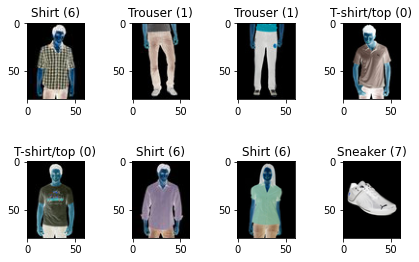

<Figure size 432x288 with 0 Axes>

In [51]:
im_arr = np.load('imagesFashionImages.npy')
label_arr = np.load('labelsFashionImages.npy')

print("Layout")
print("Images: {}".format(im_arr.shape))
print("Lables: {}".format(label_arr.shape))
print()
print("Examples")

fig, axs = plt.subplots(2, 4)
fig.tight_layout()
for i, ax in enumerate(axs.flat):
    ax.imshow(im_arr[i])
    ax.set_title(str(categories.categories[label_arr[i,0]]) + ' (' + str(int(label_arr[i,0])) +')')
plt.show()
plt.savefig('first_8_inverted.jpg')

## Loading class for new data

In [52]:
class FashionImgData(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""
    
    def __init__(self, image_data, label_data, transform = None):
        """Method to initilaize variables.""" 
        self.transform = transform
        self.labels = label_data
        # Dimension of Images = 28 * 28 * 3. where height = width = 28 and color_channels = 3.
        self.images =  image_data

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

## Define custom transforms and create loaders:

In [71]:
mnist_transforms_normfirst = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1552, 0.1725, 0.1782), (0.2477, 0.2616, 0.2658)),
    transforms.Grayscale(),
    transforms.Resize((28,28))])

mnist_transforms_normlast = transforms.Compose([
    transforms.ToTensor(),
    transforms.Grayscale(),
    transforms.Resize((28,28)),
    transforms.Normalize((0.1682,),(0.2504,),)])

fashion_data = FashionImgData(im_arr, label_arr, mnist_transforms_normlast)
print("Number of samples: {}".format(len(fashion_data.images)))
fashionloader = DataLoader(dataset=fashion_data, batch_size = 10, shuffle = False)

print("Train data shape: ")
for i, (images, labels) in enumerate(fashionloader):
    print(images.shape, labels.shape)
    if i == 5: #print only first 10
        break

Number of samples: 30175
Train data shape: 
torch.Size([10, 1, 28, 28]) torch.Size([10, 1])
torch.Size([10, 1, 28, 28]) torch.Size([10, 1])
torch.Size([10, 1, 28, 28]) torch.Size([10, 1])
torch.Size([10, 1, 28, 28]) torch.Size([10, 1])
torch.Size([10, 1, 28, 28]) torch.Size([10, 1])
torch.Size([10, 1, 28, 28]) torch.Size([10, 1])


Examples grayscale:


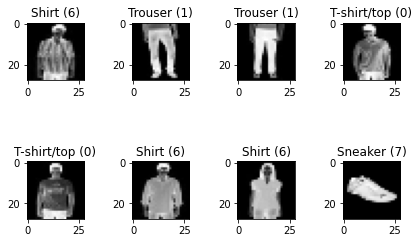

<Figure size 432x288 with 0 Axes>

In [72]:
print("Examples grayscale:")
example = iter(fashionloader)
images, labels = example.next()
fig, axs = plt.subplots(2, 4)
fig.tight_layout()
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i][0], cmap= 'gray')
    ax.set_title(str(categories.categories[labels[i].item()]) + ' (' + str(int(labels[i].item())) +')')
plt.show()
plt.savefig('first_8_grayAndSmall.jpg')

# Test model on the new data

In [73]:
accuracy, true_labels, predictions = test(model,fashionloader)

3218 30175
Test Accuracy: 10.664457332228666%


In [74]:
print(true_labels.shape)
print(predictions.shape)
print(true_labels[:20])
print(predictions[-100:])

(30175,)
(30175,)
[6. 1. 1. 0. 0. 6. 6. 7. 5. 8. 5. 6. 0. 8. 5. 2. 9. 0. 8. 6.]
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]


Example predictions:



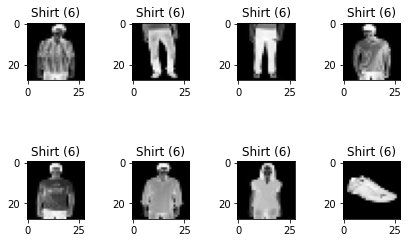

In [75]:
print("Example predictions:")
print()
example = iter(fashionloader)
images, labels = example.next()
fig, axs = plt.subplots(2, 4)
fig.tight_layout()

for i, ax in enumerate(axs.flat):
    ax.imshow(images[i][0], cmap= 'gray')
    ax.set_title(str(categories.categories[predictions[i]]) + ' (' + str(int(predictions[i])) +')')

plt.show()

In [76]:
def confusion_matrix(y_truth, y_pred, num_cats):
    n = len(y_truth)
    mat = np.zeros(shape=(num_cats,num_cats))
    for i in range(n):
        mat[int(y_truth[i]),int(y_pred[i])] += 1
    return mat

In [77]:
print(confusion_matrix(true_labels, predictions, num_cats = 10))

[[0.000e+00 0.000e+00 0.000e+00 5.000e+00 0.000e+00 0.000e+00 8.815e+03
  0.000e+00 4.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 2.100e+01 0.000e+00 0.000e+00 2.346e+03
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 4.000e+00 0.000e+00 0.000e+00 5.570e+02
  0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 2.806e+03
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.030e+02
  0.000e+00 1.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 1.853e+03
  0.000e+00 2.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 3.212e+03
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 1.000e+00 0.000e+00 0.000e+00 5.328e+03
  0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 2.000e+00 0.000e+00 0.000e+00 2.972e+03
  0.000e+00 5.000e+00 0.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.0